In [11]:
%matplotlib inline
import matplotlib as mplt 
from matplotlib import cm 
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec
import matplotlib 
from matplotlib.ticker import FuncFormatter 
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

from utils_libs import *
from utils_training import *

import pickle

# *[var_update, m_t, v_t]

In [3]:
*[[1], [2], [3]]

SyntaxError: can't use starred expression here (<ipython-input-3-6b62a8c9ead8>, line 1)

# ----- Contribution uncertainty

In [1]:
import numpy as np
from scipy.stats import truncnorm
from scipy.optimize import fmin_slsqp


def func(p, r, xa, xb):
    return truncnorm.nnlf(p, r)

def constraint(p, r, xa, xb):
    a, b, loc, scale = p
    return np.array([a*scale + loc - xa, b*scale + loc - xb])


real_l, real_r = 30, 250


# --- ground truth data

loc = 50
scale = 75


# normalized boundary
a = (real_l - loc)/scale
b = (real_r - loc)/scale

# Generate some data to work with.
r = truncnorm.rvs(a, 
                  b, 
                  loc = loc, 
                  scale = scale, 
                  size = 10000)

# --- fit

loc_guess = 30
scale_guess = 90

l_guess = (real_l - loc_guess)/scale_guess
r_guess = (real_r - loc_guess)/scale_guess

par = fmin_slsqp(func, 
                 [l_guess, r_guess, loc_guess, scale_guess], 
                 f_eqcons = constraint, 
                 args = (r, real_l, real_r),
                 iprint = False, 
                 iter = 1000)


print(p0)
print(par)

NameError: name 'p0' is not defined

In [66]:
[a_guess, b_guess, loc_guess, scale_guess]

([0.0, 2.4444444444444446, 30, 90],)

In [71]:
print(p0, par)

[0.0, 2.4444444444444446, 30, 90] [-0.31095205  2.70063449 52.71541923 73.05119655]


In [50]:
par[0]*par[-1] + par[-2]

30.00000010552779

In [51]:
par[1]*par[-1] + par[-2]

249.9999999596968

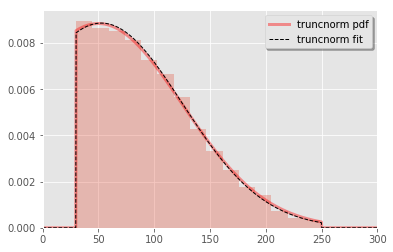

In [43]:

import matplotlib.pyplot as plt

xmin = 0
xmax = 300
x = np.linspace(xmin, xmax, 1000)

fig, ax = plt.subplots(1, 1)
ax.plot(x, truncnorm.pdf(x, a, b, loc=loc, scale=scale),
        'r-', lw=3, alpha=0.4, label='truncnorm pdf')
ax.plot(x, truncnorm.pdf(x, *par),
        'k--', lw=1, alpha=1.0, label='truncnorm fit')
ax.hist(r, bins=15, density=True, histtype='stepfilled', alpha=0.3)
ax.legend(shadow=True)
plt.xlim(xmin, xmax)
plt.grid(True)

plt.show()

In [26]:
a = [[1, ['a']], [2, ['b']], [3, ['c']]]


tmpmin = min(a, key = lambda x: x[0])
print(tmpmin)

tmpidx = a.index(tmpmin)

print(tmpidx)

[1, ['a']]
0


In [32]:
from utils_training import *

para_hpara_range = [[0.001, 0.001], [16, 80], [1e-7, 0.1]]
para_hpara_n_trial = 15

hpara_generator = hyper_para_random_search(para_hpara_range, 
                                              para_hpara_n_trial)

tmp_hpara = hpara_generator.hpara_trial()
cnt = 0

while tmp_hpara != None:
    
    print(tmp_hpara)
    
    tmp_hpara = hpara_generator.hpara_trial()
    
    cnt += 1
    
print(cnt)


AttributeError: 'hyper_para_random_search' object has no attribute 'hpara_trial'

In [29]:
from utils_training import *


para_lr_range = [0.001, ]
para_batch_range = [64, 32, 16, 80]
para_l2_range = [1e-7, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1]

hpara_generator = hpara_grid_search([para_lr_range, para_batch_range, para_l2_range])

tmp_hpara = hpara_generator.hpara_trial()
cnt = 0

while tmp_hpara != None:
    
    print(tmp_hpara)
    
    tmp_hpara = hpara_generator.hpara_trial()
    
    cnt += 1
    
print(cnt)
    

NameError: name 'hpara_grid_search' is not defined

# ----- Results Analysis

In [14]:
def mape(y, 
         yhat):
    
    tmp_list = []
    
    for idx, val in enumerate(y):
        
        if abs(val) > 1e-5:
            tmp_list.append(abs(1.0*(yhat[idx]-val)/val))
    
    return np.mean(tmp_list)

def mae(y, 
        yhat):
    
    return np.mean(np.abs(np.asarray(y) - np.asarray(yhat)))
    
def rmse(y, 
         yhat):
    
    return np.sqrt(np.mean((np.asarray(y) - np.asarray(yhat))**2))


def rmse_mae_quantiles(target, 
                       pred, 
                       q):
    
    # q = number of quantiles
    
    x_sort = sorted(list(target))

    quant_val = [x_sort[i*int(len(x_sort)/q)] for i in range(1, q)]
    quant_val.append(max(x_sort)+1)

    sq_error_quant = [0 for _ in quant_val]
    abs_error_quant = [0 for _ in quant_val]
    abs_per_error_quant = [0 for _ in quant_val]
    
    num_quant = [0 for x in quant_val]
    
    num_mape_quant = [0 for x in quant_val]
    
    for i in range(1, len(x_sort)):
        
        tmp_vol = target[i]
        tmp_resi = target[i] - pred[i]
        
        q_idx = list(map(lambda j: j>tmp_vol, quant_val)).index(True)   
        
        sq_error_quant[q_idx] += tmp_resi**2
        abs_error_quant[q_idx] += abs(tmp_resi)
        num_quant[q_idx]+=1
        
        if abs(tmp_vol)>1e-5:
            
            abs_per_error_quant[q_idx] += abs(1.0*tmp_resi/tmp_vol)
            num_mape_quant[q_idx] += 1
        
        
    rmse_quantiles = [sqrt(sq_error_quant[j]/num_quant[j]) for j in range(0, len(quant_val))] 
    mae_quantiles = [abs_error_quant[j]/num_quant[j] for j in range(0, len(quant_val))] 
    
    mape_quantiles = [abs_per_error_quant[j]/num_mape_quant[j] for j in range(0, len(quant_val))] 
    
    return rmse_quantiles, mae_quantiles, mape_quantiles, quant_val


def result_plot(y, 
                path_res, 
                plot_l, 
                plot_r, 
                plot_title):
    
    py = pickle.load(open(path_res + ".p", "rb"), \
                     encoding='latin1')

    py_mean = py[0]
    py_var = py[1]
    
    print(np.shape(ts_y))
    #print(np.shape(py))

    num = len(ts_y)
    print("MAE", mae(ts_y, py_mean))
    print("RMSE", rmse(ts_y, py_mean))
    
#   -- mean  
    fig, ax = plt.subplots(figsize=(15,8));
    
    ax.plot(range(plot_l, plot_r), ts_y[plot_l: plot_r], label = 'truth',  marker='o');
    ax.plot(range(plot_l, plot_r), py_mean[plot_l: plot_r], label = 'prediction',  marker='o');
    
    ax.set_title(plot_title)
    ax.legend()
    
#   -- variance
    fig, ax = plt.subplots(figsize=(15,5));
    
    ax.plot(range(plot_l, plot_r), py_var[plot_l: plot_r], label = 'volatility',  marker='o');
    
    ax.set_title(plot_title)
    ax.legend()
    
#   -- histogram
    fig, ax = plt.subplots();

    ax.hist(py_mean, 2000);
    ax.set_xlim([-10, 50])
    ax.set_title(plot_title)
    
#   -- quantial conditional
    rmse_quantiles, mae_quantiles, mape_quantiles, quant_val = rmse_mae_quantiles(np.squeeze(ts_y), 
                                                                                  np.squeeze(py_mean), 
                                                                                  10)
    
    print("Quantiles", quant_val, '\n')
    
    print("  RMSE", rmse_quantiles)
    print("  MAE", mae_quantiles)
    print("  MAPE", mape_quantiles)
    

def plot(py, y, plot_l, plot_r):
    
    src_dict = {0:"local trans.", 1:"external trans.", 2:"local order book", 3:"auto"}
    
    # [bayes_mean, bayes_total_var, bayes_vola, bayes_unc, bayes_gate_src, bayes_gate_src_var, g_src_sample]

    mean = py[0]
    total_v = np.sqrt(py[1])

    vol = np.sqrt(py[2])
    unc = np.sqrt(py[3])
    
    mean_low = mean - 3.0*unc
    mean_up = mean + 3.0*unc
    
    gate = py[4]
    gate_std = np.sqrt(py[5])
    
    print("gate shape: ", np.shape(gate), np.shape(py[6]))
    num_src = np.shape(gate)[1]
    
    
    # -- cross check

    np.shape(mean)
    y = np.asarray(np.squeeze(y))

    print(np.shape(mean), np.shape(y)) 
    print("cross check RMSE: ", np.sqrt(np.mean((y - mean)**2)), mae(y, mean) )
    
    
    # -- marginal distribution 
    
    fig, ax = plt.subplots();

    ax.hist(y, 2000, label = "Truth");
    ax.set_ylim([0, 200]);
    ax.set_xlim([-10, 500]);
    ax.set_title("True values in testing data");
    
    ax.hist(mean, 1000, label = "Prediction");
    ax.legend()
    

    # -- mean and uncertainty
    
    fig, ax = plt.subplots(figsize=(15,3));
    
    ax.plot(range(plot_l, plot_r), y[plot_l: plot_r], label = 'truth',\
            marker='o', color = 'k', alpha = 0.4);
    ax.plot(range(plot_l, plot_r), mean[plot_l: plot_r], label = 'prediction',\
            marker='o', color = 'b', alpha = 0.4);
    ax.fill_between(range(plot_l, plot_r), mean_low[plot_l: plot_r], mean_up[plot_l: plot_r], 
                color = '#539caf', alpha = 0.4, label = '95% CI')
    

#     ax_twin = ax.twinx()
#     ax_twin.plot(range(plot_l, plot_r), vol[plot_l: plot_r], label = 'volatility',  marker='o', alpha=.3, color = 'g');
    
    #ax2.tick_params(axis='y', labelcolor=color)
    #ax.plot(range(plot_l, plot_r), vol[plot_l: plot_r], label = 'volatility',  marker='o', alpha=.3, color = 'g');
    
    ax.set_title("Predicted mean plus confidence interval");
    ax.set_xlabel("Time");
    ax.set_ylabel("Value");
    ax.legend();
    
    
    # -- vol
    fig, ax = plt.subplots(figsize=(15,3));
    
    ax.plot(range(plot_l, plot_r), vol[plot_l: plot_r], label = 'volatility',  marker='o', alpha=.3, color = 'g');

    ax.set_title("Volatility");
    ax.set_xlabel("Time");
    ax.set_ylabel("Value");
    ax.set_ylim(20, 120);
    
  
    #  -- Contribution of different sources with confidence interval
    fig, ax = plt.subplots(figsize=(15, 3));

    X = range(plot_l, plot_r)

    for tmp_src in range(num_src):
        tmp_y = [i[tmp_src] for i in gate[plot_l: plot_r]]
        tmp_yerr = [2*i[tmp_src] for i in gate_std[plot_l: plot_r]]
    
        ax.errorbar(X, tmp_y, yerr = tmp_yerr, marker='o', label = src_dict[tmp_src], capsize = 3);
    
    ax.legend();
    ax.set_xlabel("Time");
    ax.set_ylabel("Value");
    ax.set_title("Contribution of different sources with confidence interval");

    
    # -- uncertainty
    fig, ax = plt.subplots(figsize=(15,3));
    
    ax.plot(range(plot_l, plot_r), unc[plot_l: plot_r], label = 'uncertainty',  marker='o', alpha=.3, color = 'b');

    ax.set_title("Uncertainty on predicted mean");
    ax.set_xlabel("Time");
    ax.set_ylabel("Value");
#     ax.set_ylim(0, 50);


# -- overview of mean, uncertainty, and volatility
    
    fig, ax = plt.subplots(figsize=(15,10));
    
    ax.plot(range(plot_l, plot_r), y[plot_l: plot_r], label = 'truth',\
            marker='o', color = 'k', alpha = 0.4);
    ax.plot(range(plot_l, plot_r), mean[plot_l: plot_r], label = 'prediction',\
            marker='o', color = 'b', alpha = 0.4);
    ax.fill_between(range(plot_l, plot_r), mean_low[plot_l: plot_r], mean_up[plot_l: plot_r], 
                color = '#539caf', alpha = 0.4, label = '95% CI')
    
    
    ax_twin = ax.twinx()
    ax_twin.plot(range(plot_l, plot_r), vol[plot_l: plot_r], label = 'volatility', \
                 marker='o', alpha=.8, color = 'g');
    
    
    #ax2.tick_params(axis='y', labelcolor=color)
    #ax.plot(range(plot_l, plot_r), vol[plot_l: plot_r], label = 'volatility',  marker='o', alpha=.3, color = 'g');
    
    ax.set_title("Predicted mean plus confidence interval");
    ax.set_xlabel("Time");
    ax.set_ylabel("Value");
    ax.legend();

# # -- gate

# fig, ax = plt.subplots(figsize=(15,5));

# X = range(plot_l, plot_r)

# cumu = [0.0 for j in range(plot_l, plot_r)]

# src_dict = { 0:"local trans.", 1:"external trans.", 2:"local order book"  }

# for tmp_src in range(num_src):
    
#     tmp_gate = [i[tmp_src] for i in gate[plot_l: plot_r]]
#     tmp_cumu = cumu + np.asarray(tmp_gate)
    
#     ax.plot(X, tmp_cumu, alpha=.5, label = src_dict[tmp_src]);
#     ax.fill_between(X, cumu, tmp_cumu, alpha=.5);
    
#     cumu = tmp_cumu

# ax.legend();
# ax.set_title("Contribution of different sources");
# ax.set_xlabel("Time");
# ax.set_ylabel("Value");



In [5]:
# ----- load testing data

from utils_training import *

path_data = "../dataset/bitcoin/double_trx_ob_tar5_len10/"

ts_dta = pickle.load(open(path_data + 'test.p', "rb"), 
                     encoding = 'latin1')

ts_x, ts_y = data_reshape(ts_dta,
                          bool_target_seperate = True)


tmpx = data_padding_x(ts_x, 
                      num_src = len(ts_x))
print(np.shape(tmpx))

(6870, 9, 6)
(6870, 9, 7)
(6870, 9, 8)
(6870, 9, 1)
(4, 6870, 9, 8)


[39.07148  51.372826 55.00549  ... 16.589054 17.354643 19.411718]
gate shape:  (6870, 3) (60, 6870, 3)
(6870,) (6870,)
cross check RMSE:  65.76778187740314 33.434563875314225


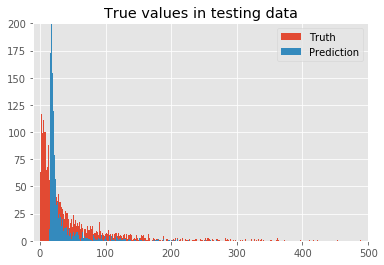

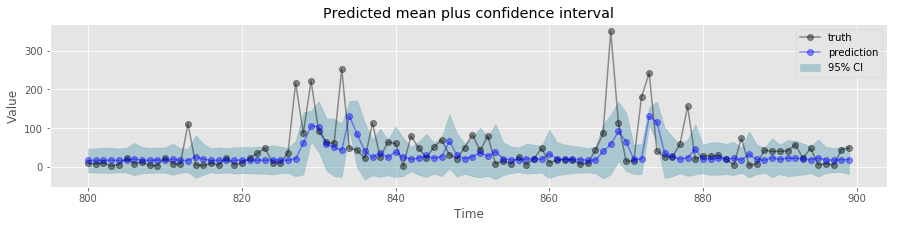

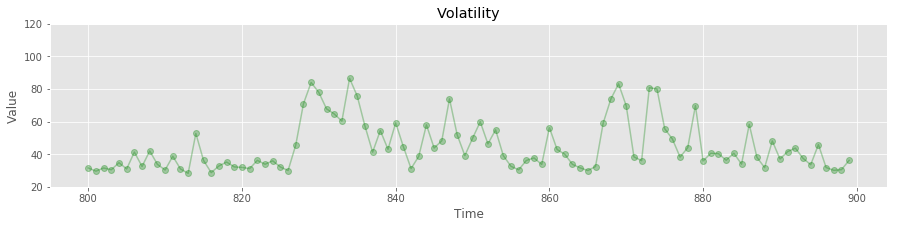

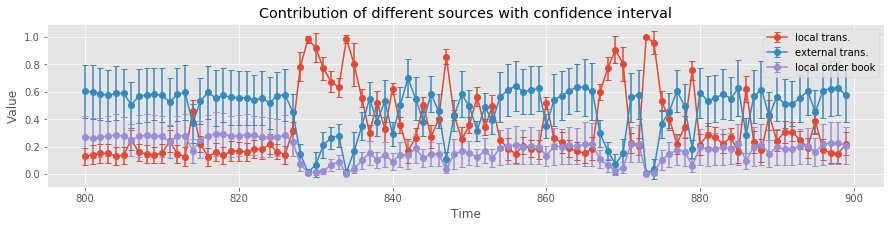

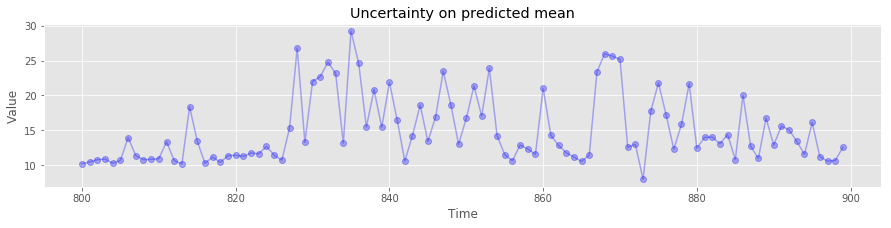

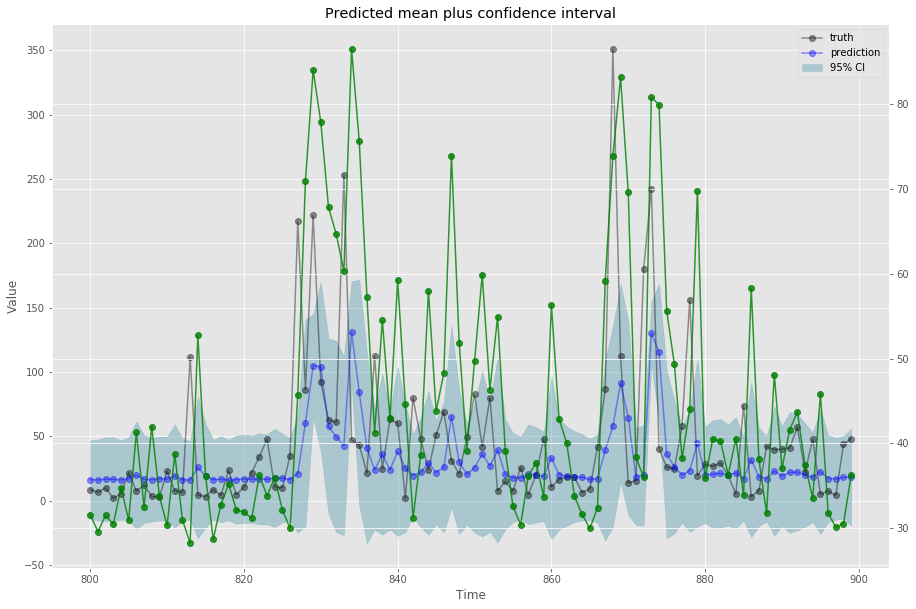

In [19]:
# Standard

path_res = "../results/mixture_tar5_len10_ensemble_vol_unc_80_60_nnllk_epoch/"


py = pickle.load(open(path_res + "py_gaussian_lk_inv_none_none" + ".p", "rb"), \
                     encoding='latin1')

# py: [bayes_mean, bayes_total_var, bayes_vola, bayes_unc, bayes_gate_src, bayes_gate_src_var, g_src_sample]

print(py[0])

plot(py,
     y = ts_y,
     plot_l = 800,
     plot_r = 900)

[13.107575  5.771382 -9.479436 ... 30.58235  27.492735 29.745886]
gate shape:  (6870, 3) (60, 6870, 3)
(6870,) (6870,)
cross check RMSE:  76.21318563324665 39.64986904810276


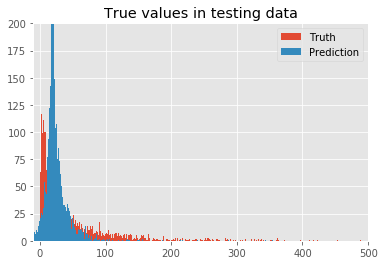

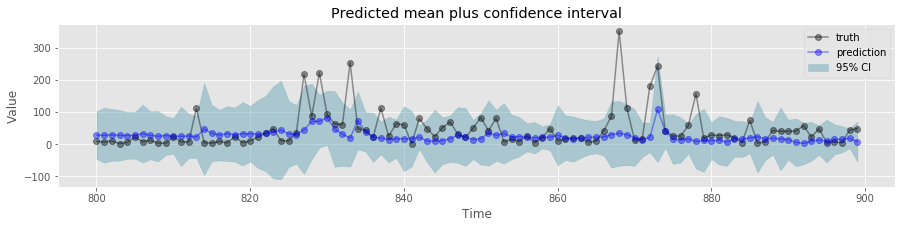

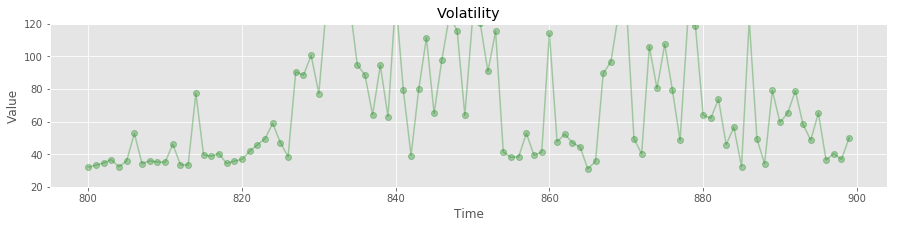

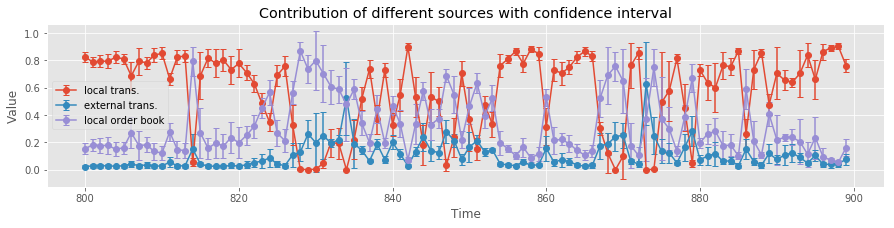

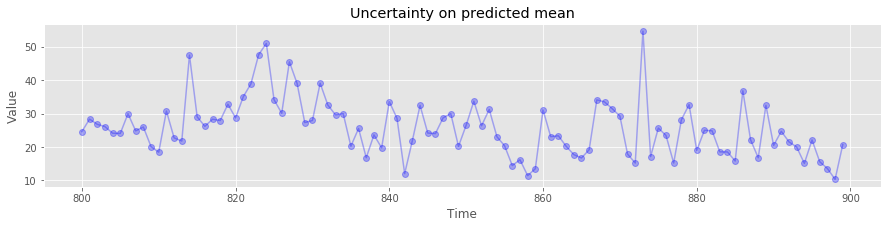

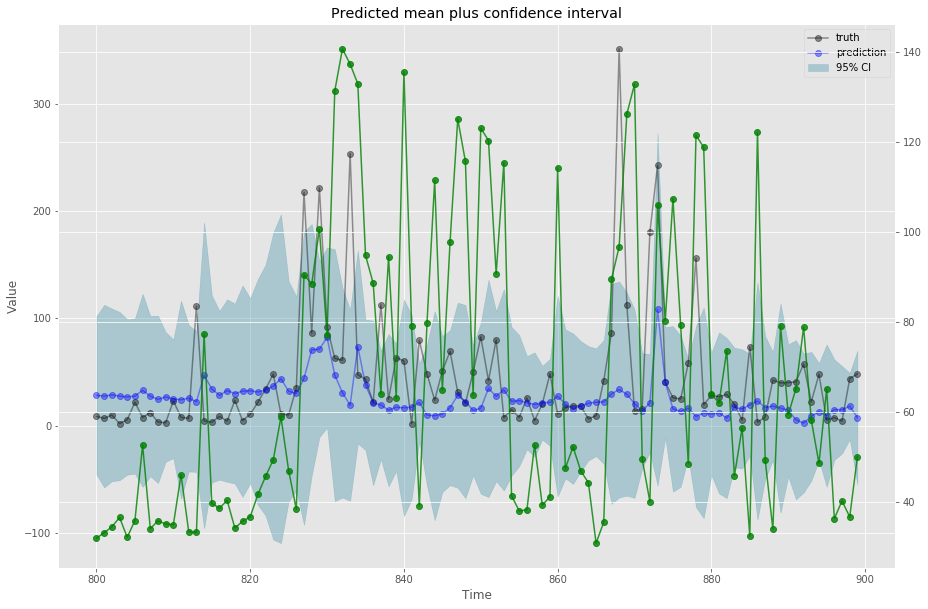

In [18]:
path_res = "../results/mixture_tar5_len10_ensemble_vol_unc_80_60_nnllk_epoch_bias_none/"

py = pickle.load(open(path_res + "py_gaussian_lk_inv_none_none" + ".p", "rb"), \
                     encoding='latin1')

# py: [bayes_mean, bayes_total_var, bayes_vola, bayes_unc, bayes_gate_src, bayes_gate_src_var, g_src_sample]

print(py[0])

plot(py,
     y = ts_y,
     plot_l = 800,
     plot_r = 900)

[25.419315 29.54231  35.409927 ... 17.961435 20.359337 19.4582  ]
gate shape:  (6870, 3) (60, 6870, 3)
(6870,) (6870,)
cross check RMSE:  67.82084757376505 34.38789484491638


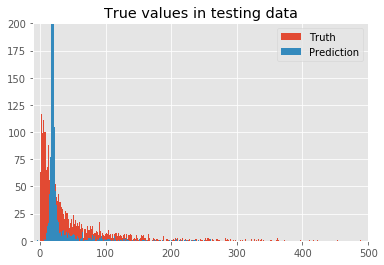

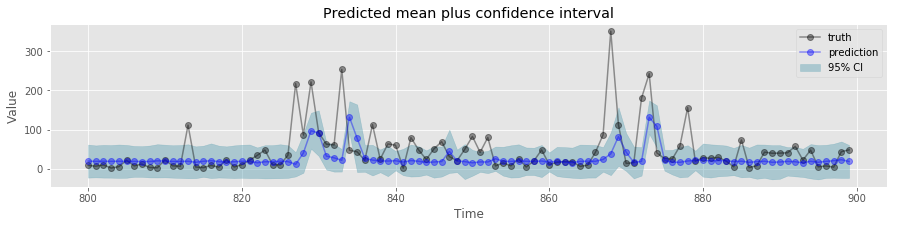

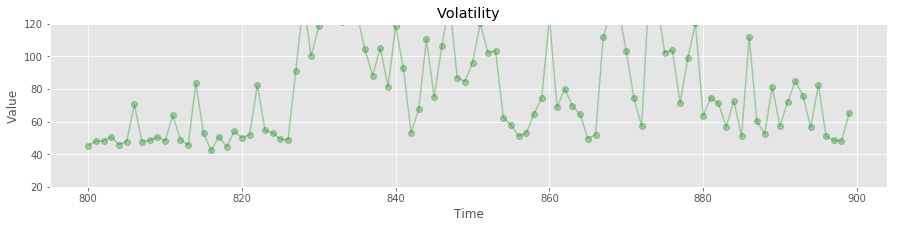

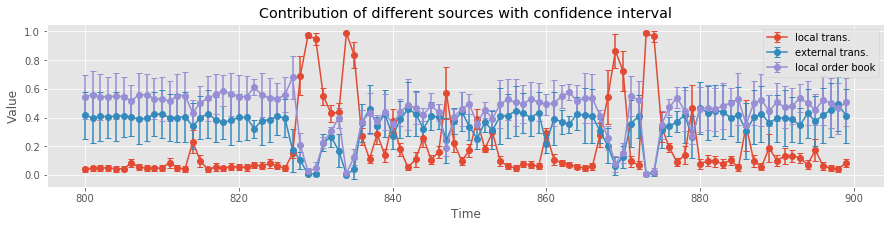

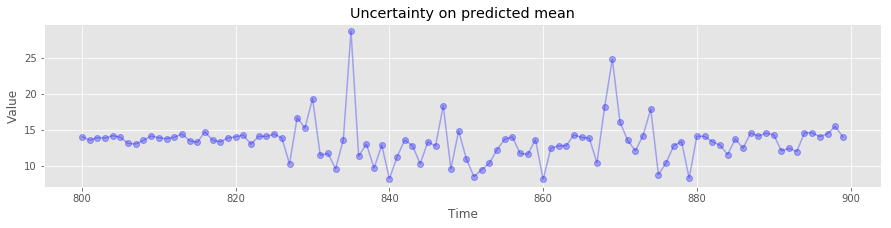

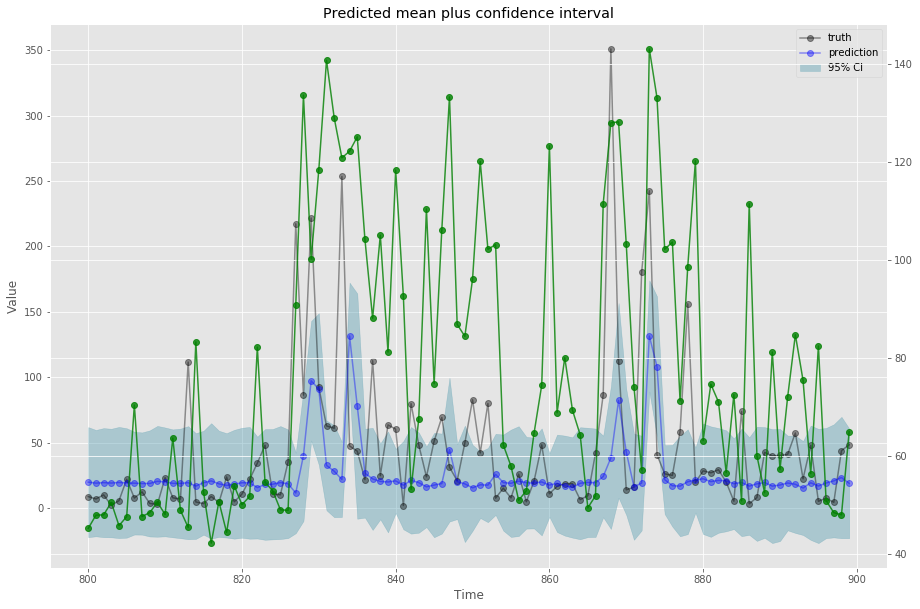

In [20]:
path_res = "../results/mixture_tar5_len10_ensemble_vol_unc_80_60_nnllk_epoch_bias_mean/"

py = pickle.load(open(path_res + "py_gaussian_lk_inv_none_none" + ".p", "rb"), \
                     encoding='latin1')

# py: [bayes_mean, bayes_total_var, bayes_vola, bayes_unc, bayes_gate_src, bayes_gate_src_var, g_src_sample]

print(py[0])

plot(py,
     y = ts_y,
     plot_l = 800,
     plot_r = 900)

[37.354477 45.751    48.29982  ... 18.10113  20.381254 20.841122]
gate shape:  (6870, 3) (60, 6870, 3)
(6870,) (6870,)
cross check RMSE:  65.50138175300066 33.765097428601


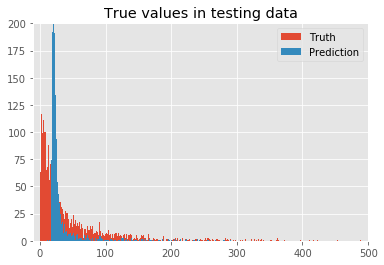

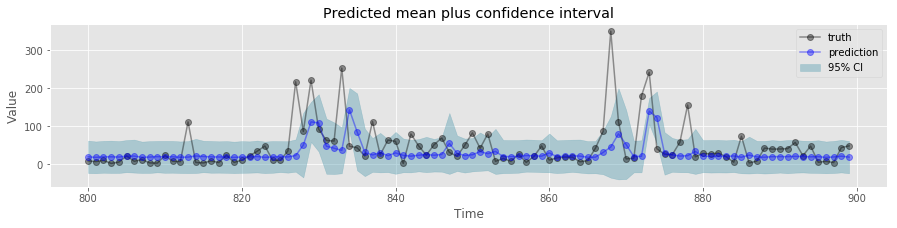

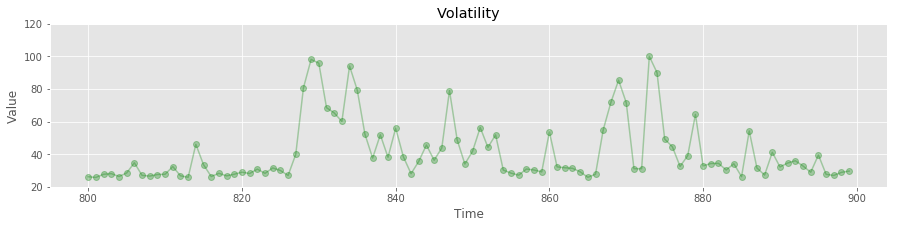

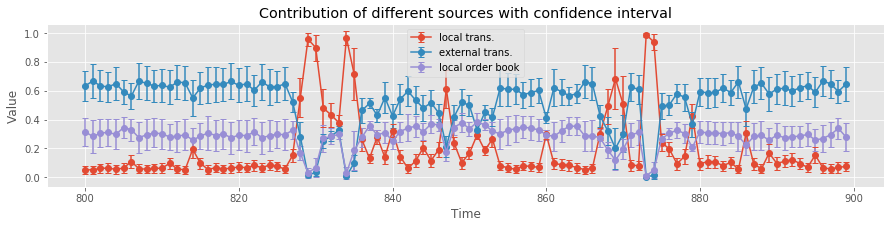

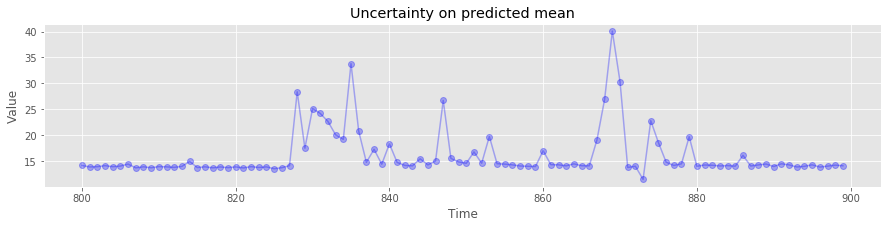

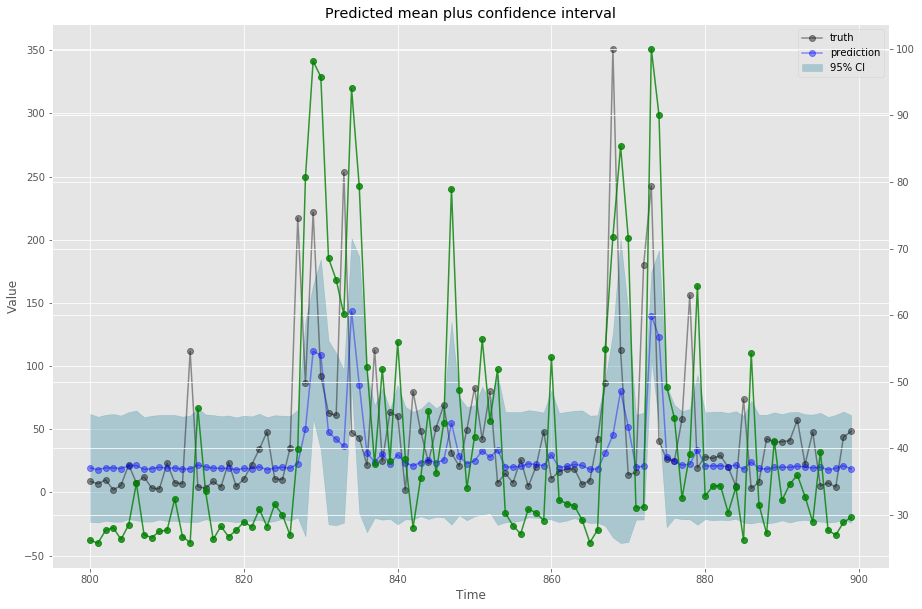

In [21]:
path_res = "../results/mixture_tar5_len10_ensemble_vol_unc_80_60_nnllk_epoch_bias_mean_var/"

py = pickle.load(open(path_res + "py_gaussian_lk_inv_none_none" + ".p", "rb"), \
                     encoding='latin1')

# py: [bayes_mean, bayes_total_var, bayes_vola, bayes_unc, bayes_gate_src, bayes_gate_src_var, g_src_sample]

print(py[0])

plot(py,
     y = ts_y,
     plot_l = 800,
     plot_r = 900)

[39.07148  51.372826 55.00549  ... 16.589054 17.354643 19.411718]
gate shape:  (6870, 3) (60, 6870, 3)
(6870,) (6870,)
cross check RMSE:  65.76778187740314 33.434563875314225


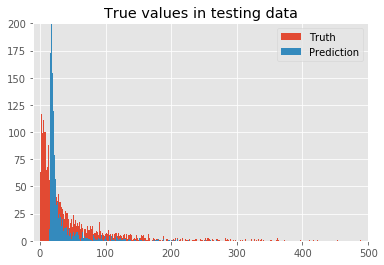

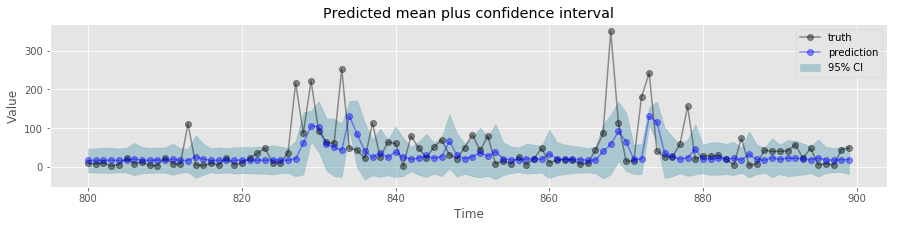

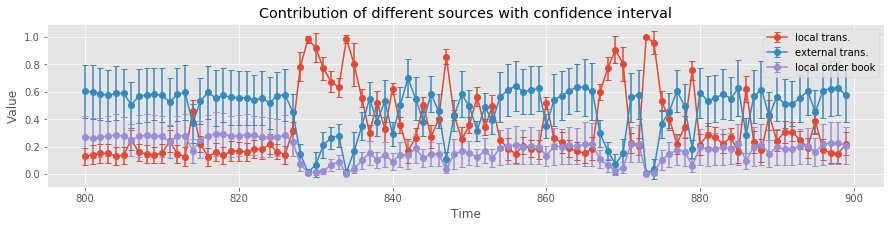

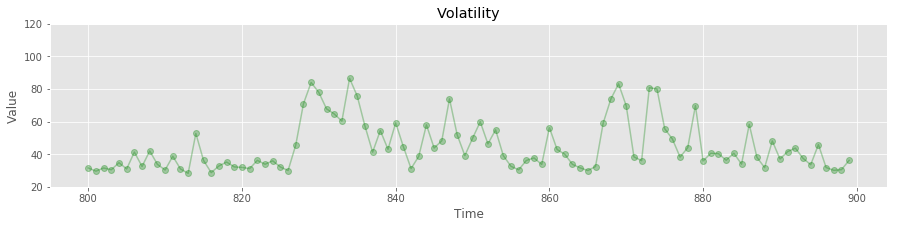

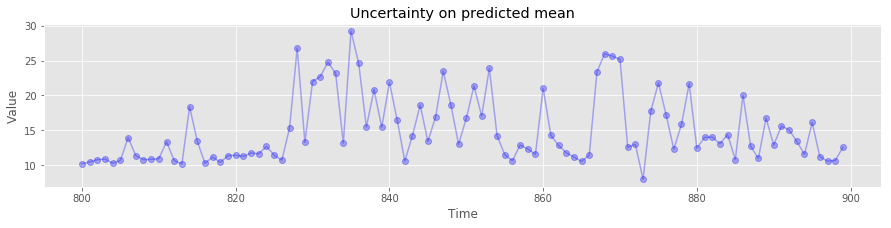

In [36]:
path_res = "../results/mixture_tar5_len10_ensemble_vol_unc_80_60_nnllk_epoch_bias_mean_var_gate/"

py = pickle.load(open(path_res + "py_gaussian_lk_inv_none_none" + ".p", "rb"), \
                     encoding='latin1')

# py: [bayes_mean, bayes_total_var, bayes_vola, bayes_unc, bayes_gate_src, bayes_gate_src_var, g_src_sample]

print(py[0])

plot(py,
     y = ts_y,
     plot_l = 800,
     plot_r = 900)

[ 7.0777035 -0.2491931 17.62882   ... 24.144712  18.90704   -3.8751593]
gate shape:  (6870, 3) (60, 6870, 3)
(6870,) (6870,)
cross check RMSE:  78.47255285102122 40.71000538438549


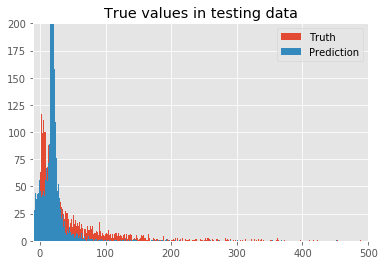

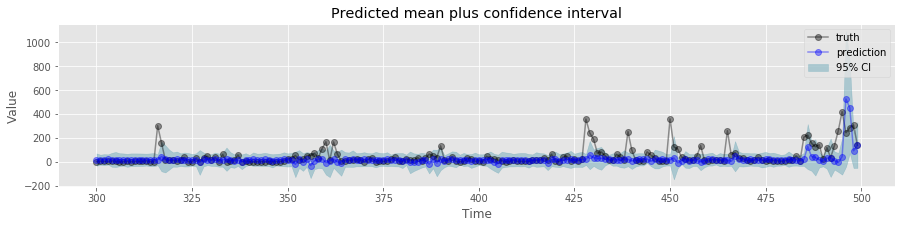

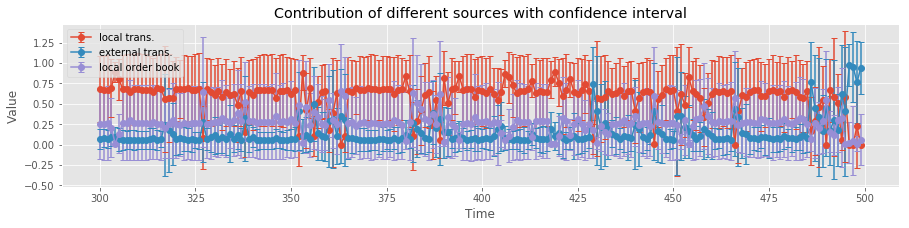

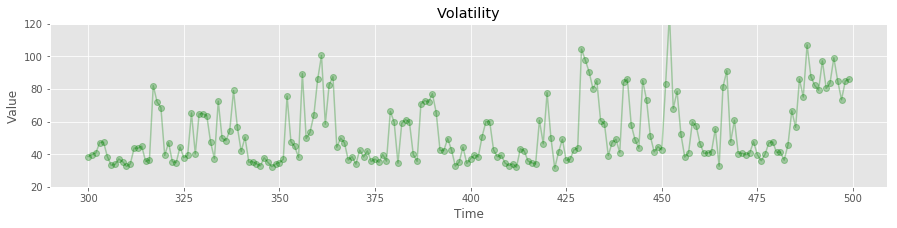

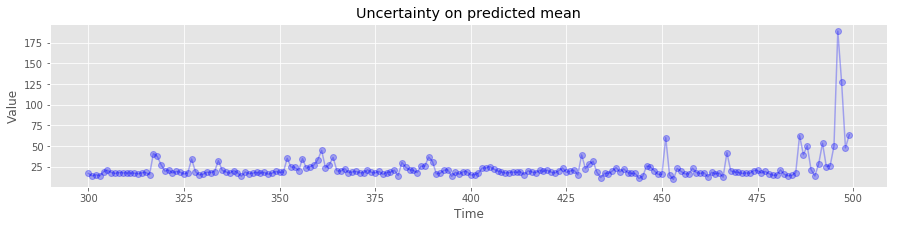

In [35]:
path_res = "../results/mixture_tar5_len10_ensemble_vol_unc_80_60_nnllk_epoch_bias_var_gate/"

py = pickle.load(open(path_res + "py_gaussian_lk_inv_none_none" + ".p", "rb"), \
                     encoding='latin1')

# py: [bayes_mean, bayes_total_var, bayes_vola, bayes_unc, bayes_gate_src, bayes_gate_src_var, g_src_sample]

print(py[0])

plot(py,
     y = ts_y,
     plot_l = 300,
     plot_r = 500)

# -----

In [ ]:
import numpy as np
from scipy.stats import truncnorm
from scipy.optimize import fmin_slsqp

import matplotlib.pyplot as plt


def func(p, r, xa, xb):
    return truncnorm.nnlf(p, r)


def constraint(p, r, xa, xb):
    a, b, loc, scale = p
    return np.array([a*scale + loc - xa, b*scale + loc - xb])


xa, xb = 30, 250 
loc = 50
scale = 75

a = (xa - loc)/scale
b = (xb - loc)/scale

# Generate some data to work with.
r = truncnorm.rvs(a, b, loc=loc, scale=scale, size=10000)

loc_guess = 30
scale_guess = 90
a_guess = (xa - loc_guess)/scale_guess
b_guess = (xb - loc_guess)/scale_guess
p0 = [a_guess, b_guess, loc_guess, scale_guess]

par = fmin_slsqp(func, p0, f_eqcons=constraint, args=(r, xa, xb),
                 iprint=False, iter=1000)

xmin = 0
xmax = 300
x = np.linspace(xmin, xmax, 1000)

fig, ax = plt.subplots(1, 1)
ax.plot(x, truncnorm.pdf(x, a, b, loc=loc, scale=scale),
        'r-', lw=3, alpha=0.4, label='truncnorm pdf')
ax.plot(x, truncnorm.pdf(x, *par),
        'k--', lw=1, alpha=1.0, label='truncnorm fit')
ax.hist(r, bins=15, density=True, histtype='stepfilled', alpha=0.3)
ax.legend(shadow=True)
plt.xlim(xmin, xmax)
plt.grid(True)

plt.show()

src 0 :  (24042, 9, 7)
src 1 :  (24042, 9, 7)
src 2 :  (24042, 9, 8)
src 0 :  (3434, 9, 7)
src 1 :  (3434, 9, 7)
src 2 :  (3434, 9, 8)
src 0 :  (6870, 9, 7)
src 1 :  (6870, 9, 7)
src 2 :  (6870, 9, 8)


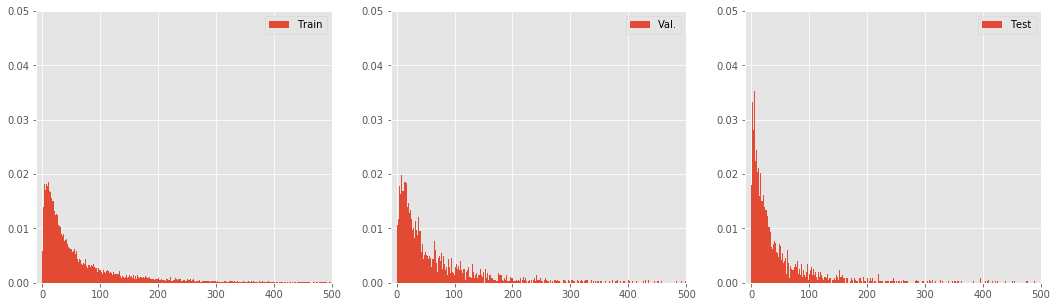

In [19]:
path_data = "../dataset/bitcoin/double_trx_ob_tar5_len10/"


tr_dta = pickle.load(open(path_data + 'train.p', "rb"), encoding = 'latin1')    
tr_x, tr_y = data_reshape(tr_dta,
                          bool_target_seperate = False)


val_dta = pickle.load(open(path_data + 'val.p', "rb"), encoding = 'latin1')
val_x, val_y = data_reshape(val_dta,
                          bool_target_seperate = False)


ts_dta = pickle.load(open(path_data + 'test.p', "rb"), encoding = 'latin1')
ts_x, ts_y = data_reshape(ts_dta,
                          bool_target_seperate = False)

fig, ax = plt.subplots(nrows = 1, ncols = 3,figsize=(18,5));

ax[0].hist(tr_y, 2000, label = 'Train', density = True);
ax[0].legend()
ax[0].set_xlim([-10, 500]);
ax[0].set_ylim([0, 0.05]);

ax[1].hist(val_y, 2000, label = 'Val.', density = True);
ax[1].legend()
ax[1].set_xlim([-10, 500]);
ax[1].set_ylim([0, 0.05]);

ax[2].hist(ts_y, 2000, label = 'Test', density = True);
ax[2].legend()
ax[2].set_xlim([-10, 500]);
ax[2].set_ylim([0, 0.05]);

# ax.set_xlim([-10, 500]);
# ax.set_title("True values in training data");

# # fig, ax = plt.subplots();
# ax.hist(val_y, 2000, label = 'Val.');
# ax.set_xlim([-10, 500]);
# ax.set_title("True values in validation data");


# # fig, ax = plt.subplots();
# ax.hist(ts_y, 2000, label = 'Test');
# ax.set_xlim([-10, 500]);
# ax.set_title("True values in testing data");




In [61]:
plot_l = 1600
plot_r = 2600

path_res = "../results/mixture_gc_py_tar_1min/" 

for tmp_path in gaussian_lk_inv:
    
    print("\n -------- ", tmp_path)
    
    result_plot(ts_y, 
                path_res + tmp_path, 
                plot_l, 
                plot_r, 
                tmp_path)